In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid", font_scale=1)

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

from sklearn.metrics import (
  mean_absolute_error,
  mean_squared_error,
  mean_absolute_percentage_error,
  accuracy_score,
  f1_score
)

from sklearn.utils import resample

import random

In [2]:
%load_ext autoreload
%autoreload

In [3]:
from felere.common.datasets import FashionMNISTDataset
X, y = FashionMNISTDataset().generate(to_float=True)

/Users/locllos/anaconda3/envs/DS-3.10/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/locllos/anaconda3/envs/DS-3.10/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/locllos/anaconda3/envs/DS-3.10/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <8D12B66B-8201-3B14-9493-21C65A8AFE8F> /Users/locllos/anaconda3/envs/DS-3.10/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


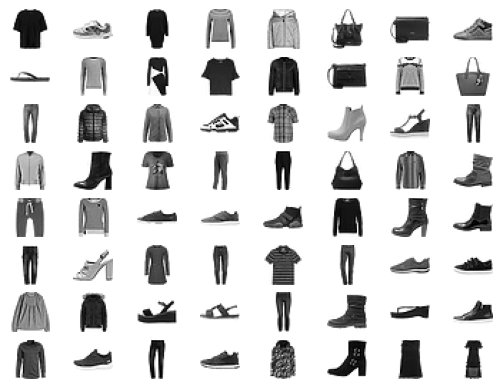

In [4]:
for i in range(64):
    ax = plt.subplot(8, 8, i+1)
    ax.axis('off')
    img = X[random.randint(0, X.shape[0])]

    plt.imshow(img, cmap=plt.cm.binary)

In [5]:
n_classes = len(np.unique(y))
print(f"{n_classes=}")

n_classes=10


In [6]:
n_features = X.shape[1] * X.shape[2]
n_targets = n_classes

In [7]:
print("reshaping X...")
X = np.float32(X).reshape((X.shape[0], X.shape[1] * X.shape[2]))
print(f"{X.dtype=}")

reshaping X...
X.dtype=dtype('float32')


In [8]:
print(f"{X.shape=}")

X.shape=(70000, 784)


In [9]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
from felere.common.distributor import DataDistributor
from felere.optimization.federative.api import BaseFederatedOptimizer
from felere.optimization.federative.fedavg import FederatedAveraging, Simulation
from felere.optimization.federative.scaffnew import Scaffnew
from felere.optimization.federative.scaffold import Scaffold
from felere.optimization.federative.fedfair import FedFair
from felere.optimization.federative.simple import Custom
from felere.optimization.federative.fedprox import FedProx

In [11]:
from felere.function.torch import TorchFunction

In [12]:
import torch

In [13]:
from felere.function.torch_models import FashionMNISTLinearModel

In [14]:
torch_model = FashionMNISTLinearModel(n_features=n_features, n_targets=n_classes)
function = TorchFunction(torch_model, torch.nn.CrossEntropyLoss())

In [15]:
print(f"{torch_model.n_paramaters()=}")

torch_model.n_paramaters()=101770


In [16]:
distributor = DataDistributor(test_size=0.3, server_fraction=0.2)

In [17]:
from felere.pipeline.pipeline import Pipeline

In [19]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
class Custom(BaseFederatedOptimizer):
  def __init__(self, eta):
    self.eta: float = eta      
    
  def play_round(self, model: Simulation):
    _, clients_weights, other = model.clients_update(self.client_update)
    clients_n_samples = other["n_samples"]
      
    next_global_weights = \
      (clients_weights * clients_n_samples).sum(axis=0) / clients_n_samples.sum()
    
    model.server.function.update(
      (-1) * (model.server.function.weights() - next_global_weights)
    )

  def client_update(self, server, client):
    client.function.update(
      (-1) * (client.function.weights() - server.function.weights())
    )
    client.function(X=client.X, y=client.y)

    step = (-1) * self.eta * client.function.grad()
    client.function.update(step)
    
    client.other["n_samples"] = client.X.shape[0]
    return client
  

  def __repr__(self):
    return "CustomMethod"


CustomMethod for parameters:  n_clients=96,  iid_fraction=0.0,  clients_fraction=0.2,  rounds=16
 eta=0.005:


learning: 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]


f1_score : 0.24480349069045879

CustomMethod for parameters:  n_clients=96,  iid_fraction=0.8,  clients_fraction=0.2,  rounds=16
 eta=0.005:


learning: 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]


f1_score : 0.2465606811598734
done


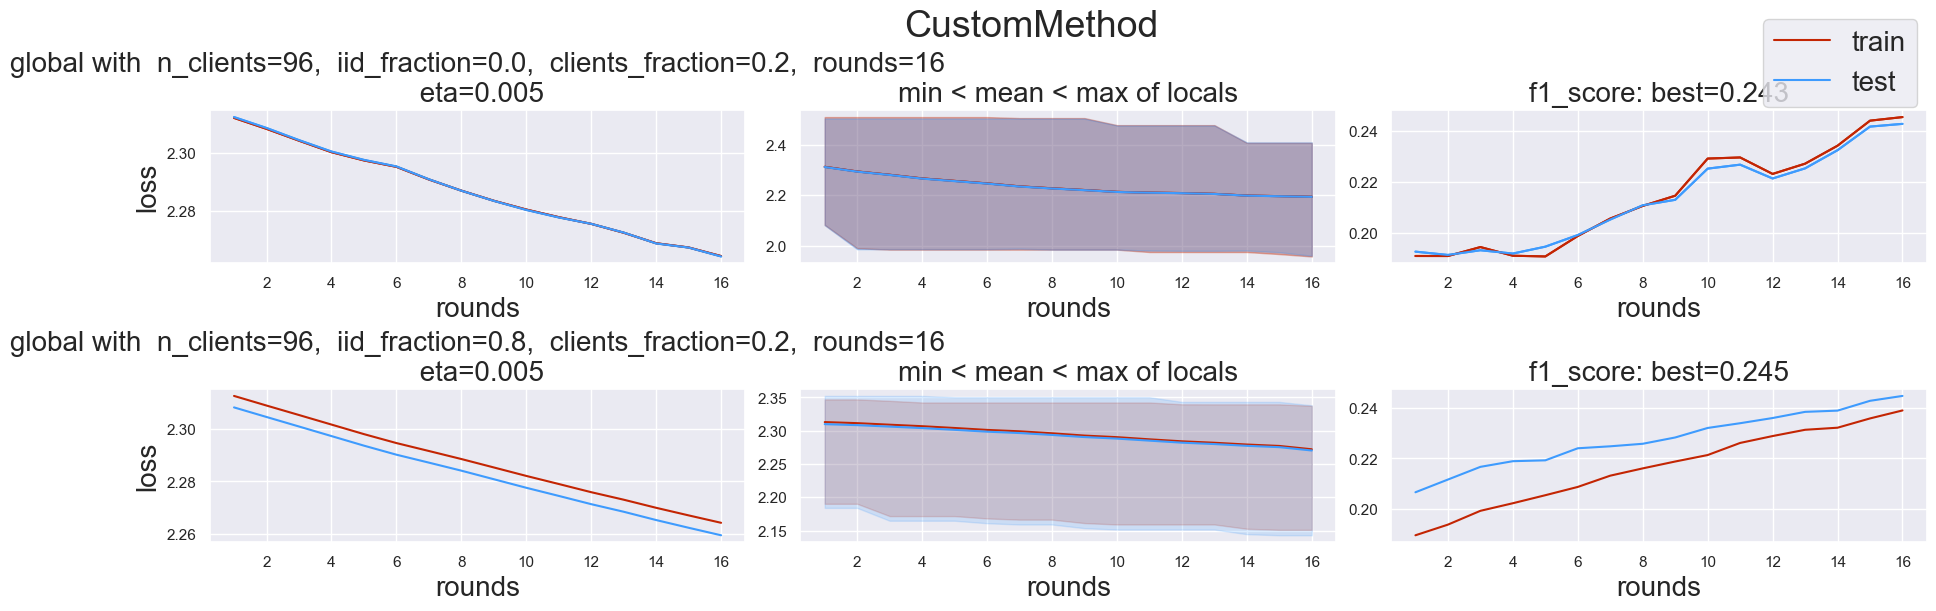

In [24]:
optimizer_parameters = {
  Custom : {
    "n_clients" : [96],
    "iid_fraction" : [0.0, 0.8],
    "clients_fraction": [0.2],
    "rounds": [16],
    "eta": [0.5e-2],
  }
}

metrics = {
  "f1_score" : lambda y_proba, y_true: f1_score(np.argmax(y_proba, axis=1), y_true, average="weighted")
}

pipeline = Pipeline(
  function=function,
  metrics=metrics,
  optimizer_parameters=optimizer_parameters,
  distributor=distributor,
  X=X,
  y=y,
  subplot_height=6,
  font_size=20
)

best, best_params = pipeline.run(choose_best_by="f1_score")

print("done")